# Partial Supervised Tagger

##### Notebook to test the partial supervised tagger and understand it better

In [1]:
%load_ext autoreload
%autoreload 2

import random
import sys
sys.path.append('../')
import torch
import time
import tqdm
import numpy as np
import random

from typing import Dict, Any
from matplotlib import pyplot as plt
from torch.nn import Linear
from transformers import BertTokenizer, BertModel
from torch_struct import LinearChainCRF
model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/opt/anaconda3/envs/notebooks/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## CRF with torch_struct

/opt/anaconda3/envs/notebooks/lib/python3.8/site-packages/torch/distributions/distribution.py:44: UserWarning: <class 'torch_struct.distributions.LinearChainCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


([<matplotlib.axis.YTick at 0x169e2c8b0>,
 [Text(0, 0, 'O'),
  Text(0, 1, 'B-PER'),
  Text(0, 2, 'I-PER'),
  Text(0, 3, 'B-LOC'),
  Text(0, 4, 'I-LOC')])

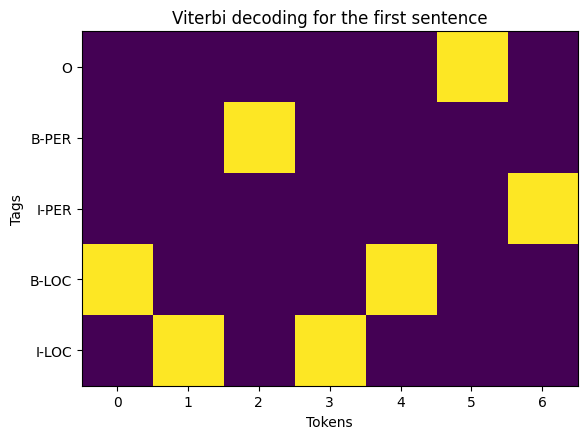

In [2]:
batch, N, C = 3, 7, 5
def show_chain(chain):
    plt.imshow(chain.detach().sum(-1).transpose(0, 1))

# batch, N, z_n, z_n_1
log_potentials = torch.rand(batch, N, C, C)
dist = LinearChainCRF(log_potentials)
show_chain(dist.argmax[0])
plt.title("Viterbi decoding for the first sentence")
plt.xlabel("Tokens")
plt.ylabel("Tags")
plt.yticks(range(C), ['O', 'B-PER', 'I-PER', 'B-LOC', 'I-LOC'])

In [3]:
dist.sample

([<matplotlib.axis.YTick at 0x28fd94ee0>,
 [Text(0, 0, 'O'),
  Text(0, 1, 'B-PER'),
  Text(0, 2, 'I-PER'),
  Text(0, 3, 'B-LOC'),
  Text(0, 4, 'I-LOC')])

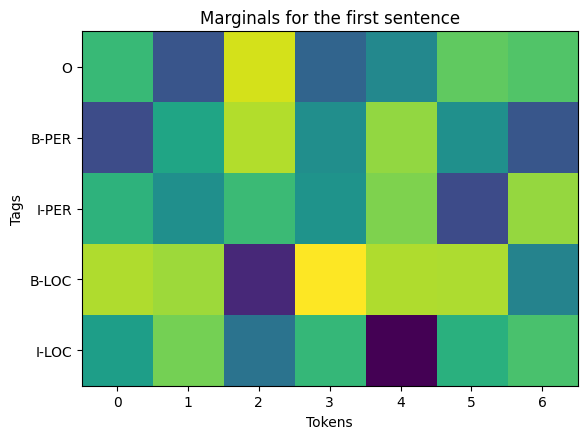

In [4]:
show_chain(dist.marginals[0])
plt.title("Marginals for the first sentence")
plt.xlabel("Tokens")
plt.ylabel("Tags")
plt.yticks(range(C), ['O', 'B-PER', 'I-PER', 'B-LOC', 'I-LOC'])



In [7]:
# -----------------------------------------------------------------------------
# constraints = torch.ones(num_tags, num_tags)
# transition_params = torch.nn.Parameter(0.001 * torch.randn_like(constraints))
# -----------------------------------------------------------------------------

def show(x): 
    with torch.no_grad():
        im = plt.imshow(x)
        plt.colorbar(im, orientation='vertical')
        plt.yticks([])


# show(transition_params)

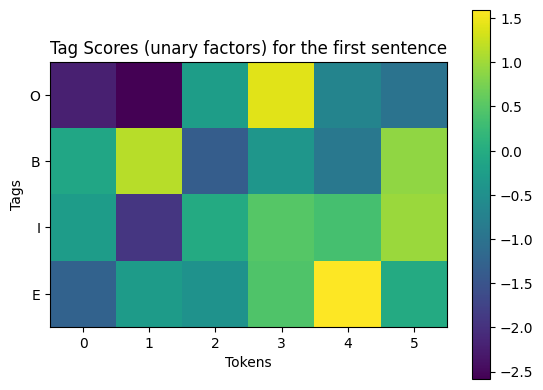

In [8]:
output = {}

B = 8 # Batch size
N = 6 # Number of tokens
C = 4 # Number of tags

tag_scores = torch.randn(B, N, C) # Random scores, shape: (batch_size, num tokens, num_tags)
show(tag_scores[0].T)
plt.title("Tag Scores (unary factors) for the first sentence")
plt.xlabel("Tokens")
plt.ylabel("Tags")
plt.yticks(range(C), ['O', 'B', 'I', 'E'])

output["local_potentials"] = tag_scores


In [9]:
# Output of the LinearCRF

batch, N, C = 3, 7, 2

# batch, N, z_n, z_n_1
log_potentials = torch.rand(batch, N, C, C)
dist = LinearChainCRF(log_potentials, lengths=torch.tensor([N-1, N, N+1]))
print(dist.struct.from_parts(dist.argmax[:, :-1])[0])
# show_chain(dist.argmax[0])
# plt.show()
# show_chain(dist.argmax[1])
# plt.show()
# show_chain(dist.argmax[2])

tensor([[1, 1, 0, 0, 1, 1, 0],
        [0, 1, 0, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 1]])


In [10]:
# Calculate log potentials from local potentials
B, N, C = 3, 10, 5

local_potentials = torch.randn(B, N, C)  # Random scores, shape: (batch_size, num tokens

""" Convert per-tag potentials to linear-chain """
# B, N, C = local_potentials.shape
potentials = local_potentials.unsqueeze(2).repeat(1, 1, C, 1) # shape : B*N*C*C

print(potentials.shape)
add_transitions = True
if add_transitions:
    constraints = torch.ones(C, C)
    # Randomly add some constraints 
    constraints_tensor = torch.randn_like(constraints)
    constraints_tensor[0, 1] = -1e10
    constraints_tensor[1, 0] = -1e10
    transition_params = torch.nn.Parameter(0.001 * constraints_tensor)
    print(transition_params)
    
    transitions = transition_params.t() 
    print(transitions)
    transitions = transitions.reshape(1, 1, C, C).repeat(B, N, 1, 1)
    print(transitions[0,0,:,:])
    potentials = potentials + transitions    
    print(potentials[0,0,:,:])
    

torch.Size([3, 10, 5, 5])
Parameter containing:
tensor([[-2.5122e-04, -1.0000e+07,  3.8313e-04, -1.0859e-04, -7.6885e-04],
        [-1.0000e+07,  5.7364e-04,  5.0496e-04, -8.2587e-05,  4.6094e-04],
        [ 8.1733e-04,  1.4281e-03, -1.2098e-03, -1.5858e-03,  9.5228e-04],
        [-4.1574e-04, -8.5970e-04, -1.1535e-03,  2.7061e-03,  3.1526e-04],
        [-1.9830e-03, -3.3571e-04, -1.1009e-03,  2.7205e-04,  3.3153e-04]],
       requires_grad=True)
tensor([[-2.5122e-04, -1.0000e+07,  8.1733e-04, -4.1574e-04, -1.9830e-03],
        [-1.0000e+07,  5.7364e-04,  1.4281e-03, -8.5970e-04, -3.3571e-04],
        [ 3.8313e-04,  5.0496e-04, -1.2098e-03, -1.1535e-03, -1.1009e-03],
        [-1.0859e-04, -8.2587e-05, -1.5858e-03,  2.7061e-03,  2.7205e-04],
        [-7.6885e-04,  4.6094e-04,  9.5228e-04,  3.1526e-04,  3.3153e-04]],
       grad_fn=<TBackward0>)
tensor([[-2.5122e-04, -1.0000e+07,  8.1733e-04, -4.1574e-04, -1.9830e-03],
        [-1.0000e+07,  5.7364e-04,  1.4281e-03, -8.5970e-04, -3.3571e

([<matplotlib.axis.YTick at 0x2b1c6ba30>,
 [Text(0, 0, 'O'),
  Text(0, 1, 'B-PER'),
  Text(0, 2, 'I-PER'),
  Text(0, 3, 'B-LOC'),
  Text(0, 4, 'I-LOC')])

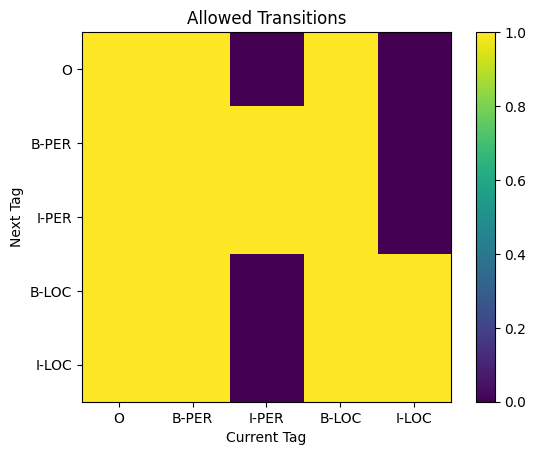

In [15]:
from ml.util.grammatical_transitions import allowed_transitions

show(constraints)
plt.title("Allowed Transitions")
plt.xlabel("Current Tag")
plt.ylabel("Next Tag")
plt.xticks(range(C), ['O', 'B-PER', 'I-PER', 'B-LOC', 'I-LOC'])
plt.yticks(range(C), ['O', 'B-PER', 'I-PER', 'B-LOC', 'I-LOC'])

In [63]:
tag_scores = torch.rand(B, N, C) # Random scores, shape: (batch_size, num tokens, num_tags)
tags = tag_scores.argmax(-1)
print("Observed tags: ", tags)
masks = (tags != 5).float()
print("Mask for padding: ", masks)

Observed tags:  tensor([[4, 1, 3, 3, 3, 3, 2, 2, 0, 1],
        [4, 1, 3, 0, 4, 4, 1, 1, 0, 2],
        [3, 2, 4, 2, 3, 2, 2, 2, 2, 0]])
Mask for padding:  tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])


In [245]:
allowed_transitions("BIO", labels={0: "O", 1: "B-PER", 2: "I-PER", 3: "B-LOC", 4: "I-LOC"})

tensor([[1., 1., 0., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 0., 1., 1.],
        [1., 1., 0., 1., 1.]])

shape tag_scores : torch.Size([3, 10, 5]) it is B*N*C because there are B sentence with N tokens and C tags possible
shape log_phis : torch.Size([3, 10, 5, 5]) it is B*N*C*C because there are B sentence with N tokens and N tags possible * N possible transitions. (The last two dimensions are for the transitions.)
tensor([[ 1.2328e-02,  1.9290e-01,  3.7693e-01,  2.8986e-01,  1.3049e-01],
        [ 1.2105e-02,  1.9245e-01,  3.7700e-01,  2.9027e-01,  1.2926e-01],
        [-1.0000e+05,  1.9158e-01,  3.7790e-01, -1.0000e+05, -1.0000e+05],
        [ 1.2667e-02,  1.9223e-01,  3.7812e-01,  2.9077e-01,  1.2784e-01],
        [-1.0000e+05, -1.0000e+05, -1.0000e+05,  2.8912e-01,  1.2873e-01]],
       grad_fn=<SelectBackward0>)
tensor([[ 8.8530e-02,  3.1387e-01,  3.1110e-01,  1.4198e-01,  1.4703e-01],
        [ 8.8307e-02,  3.1342e-01,  3.1117e-01,  1.4240e-01,  1.4580e-01],
        [-1.0000e+05,  3.1255e-01,  3.1207e-01, -1.0000e+05, -1.0000e+05],
        [ 8.8870e-02,  3.1320e-01,  3.1229e-01,  1.

/opt/anaconda3/envs/notebooks/lib/python3.8/site-packages/torch/distributions/distribution.py:44: UserWarning: <class 'torch_struct.distributions.LinearChainCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


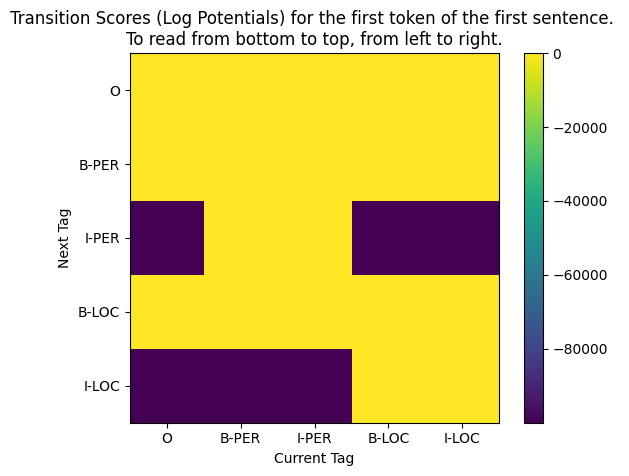

In [64]:
# Calculate log potentials from local potentials
def _expand_potentials(local_potentials: torch.FloatTensor, add_transitions: bool = True
) -> torch.FloatTensor:
    """ Convert per-tag potentials to linear-chain.  
    """
    constraints = allowed_transitions("BIO", labels={0: "O", 1: "B-PER", 2: "I-PER", 3: "B-LOC", 4: "I-LOC"})
    B, N, C = local_potentials.shape
    potentials = local_potentials.unsqueeze(2).repeat(1, 1, C, 1) # shape: B*N*C*C
    
    if add_transitions:
        transition_params = torch.nn.Parameter(0.001 * torch.randn_like(constraints))
        transitions = transition_params.t()  # flip to c_{i+1}, c_i # shape: C*C
        transitions = transitions.reshape(1, 1, C, C).repeat(B, N, 1, 1) # shape: B*N*C*C
        potentials = potentials + transitions   # shape: B*N*C*C
    return potentials

def _constrain_transitions(log_phis: torch.FloatTensor, weight=1e5) -> torch.FloatTensor:
    constraints = allowed_transitions("BIO", labels={0: "O", 1: "B-PER", 2: "I-PER", 3: "B-LOC", 4: "I-LOC"})
    transition_constraints = torch.nn.Parameter(constraints.float(), requires_grad=False)
    # print("transition_constraints: ", transition_constraints)
    B, N, C, _ = log_phis.shape
    ok_transitions = (
        transition_constraints.t().reshape(1, 1, C, C).repeat(B, N, 1, 1)
    )  # flip from c_{i},c_{i+1} to c_{i+1},c_{i}
    # print("log_phis: ", log_phis[0,0,:,:])
    log_phis = log_phis + -weight * (1 - ok_transitions)
    # print("log_phis: ", log_phis[0,0,:,:])
    return log_phis

tag_scores = torch.rand(B, N, C) # Random scores, shape: (batch_size, num tokens, num_tags)
log_phis = _expand_potentials(tag_scores, add_transitions=True)

# Maybe constrain the potentials with grammar matrix by adding -INF to all disallowed transitions
log_phis = _constrain_transitions(log_phis)
print("shape tag_scores :", tag_scores.shape, "it is B*N*C because there are B sentence with N tokens and C tags possible")
print("shape log_phis :", log_phis.shape, "it is B*N*C*C because there are B sentence with N tokens and N tags possible * N possible transitions. (The last two dimensions are for the transitions.)")

show(log_phis[0, 0])
print(log_phis[0, 0])
print(log_phis[1,1])
plt.title("Transition Scores (Log Potentials) for the first token of the first sentence. \nTo read from bottom to top, from left to right.")
plt.xlabel("Current Tag")
plt.ylabel("Next Tag")
plt.xticks(range(C), ['O', 'B-PER', 'I-PER', 'B-LOC', 'I-LOC'])
plt.yticks(range(C), ['O', 'B-PER', 'I-PER', 'B-LOC', 'I-LOC'])

mask = (tags != 5).float()
lengths = mask.long().sum(-1) + 1  # torch_struct expects N+1 as the size
output["pred_crf"] = crf_ = LinearChainCRF(log_phis, lengths=lengths)

In [225]:
print(crf_.partition)
# Get sum on last dimension of log_phis
mask = log_phis>0


print(tag_scores.shape)
print(tag_scores.logsumexp(dim=2).shape)
print(torch.where(mask, log_phis, torch.tensor(0.0)).logsumexp(2).shape)
# Manually calculate the partition function from the log potentials (log_phis)

# (log_phis[mask].sum(dim=1))
 # .logsumexp(2).sum(-1))


tensor([16.7476, 16.8631, 16.7209], grad_fn=<SqueezeBackward1>)
torch.Size([3, 10, 5])
torch.Size([3, 10])
torch.Size([3, 10, 5])


([<matplotlib.axis.YTick at 0x2c0ee6d30>,
 [Text(0, 0, 'O'), Text(0, 1, 'B'), Text(0, 2, 'I'), Text(0, 3, 'E')])

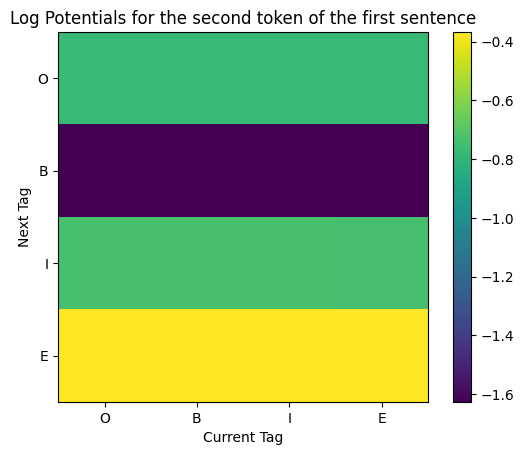

In [47]:
show(log_phis[0, 1].T)
plt.title("Log Potentials for the second token of the first sentence")
plt.xlabel("Current Tag")
plt.ylabel("Next Tag")
plt.xticks(range(C), ['O', 'B', 'I', 'E'])
plt.yticks(range(C), ['O', 'B', 'I', 'E'])

## Loss with Partial Labeling + Expected Entity Ratio

In [248]:
B, N, C = 3, 10, 5

tags = torch.randint(0, C, (B, N))  # Random tags, shape: (batch_size, num tokens)
print("Observed tags: ", tags)
masks = (tags != 6).float()
print("Mask for padding: ", masks)
local_potentials = torch.randn(B, N, C)  # Random scores, shape: (batch_size, num tokens, num_tags)
log_phis = _expand_potentials(local_potentials, add_transitions=True)
pred_crf = LinearChainCRF(log_phis, lengths=torch.tensor([N-1, N, N+1]))

def _constrain_potentials(tags: torch.LongTensor, local_potentials: torch.FloatTensor) -> torch.FloatTensor:
    """To do partially supervised learning, we convert the provided tags into potentials for a constrained crf.

    The index 0 is assumed to mean "latent". Say we have 2 real tags and are given the sequence:
      [ 0, 1, 2, 0]

    The resulting additive observations mask would be
      [[ 0.0, 0.0 ],
       [ 0.0, -inf],
       [ -inf, 0.0],
       [ 0.0, 0.0 ]]
    If we add this to the potentials for a crf, the resulting CRF will be effectively constrained to "1","2" at 1,2
    but leaving the end positions unconstrained.
    """
    mask = torch.zeros_like(local_potentials)
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            tag = tags[i, j]
            if tag > 0:
                mask[i, j, :] = -1e10 # Set to -inf
                mask[i, j, tag - 1] = 0.0
    return local_potentials + mask 
# print(local_potentials[0,:,:])

# 1. Transform the labels/observations into a LinearChainCRF object with the observed tags only (y_{1:n} \in y_O) so that we can compare it with the actual predictions which are in the LinearChainCRF format
constrained_pred_potentials = _expand_potentials(
            _constrain_potentials(tags, local_potentials),
            add_transitions=True,
        )

observed_tags_pred_crf = LinearChainCRF(constrained_pred_potentials, lengths=pred_crf.lengths)
output["observed_tags_pred_crf"] = observed_tags_pred_crf

# 2. Calculate the loss from the two LinearChainCRF objects

supervised_loss = (observed_tags_pred_crf.partition - pred_crf.partition).mean()
print("supervised_loss: ", supervised_loss)


Observed tags:  tensor([[0, 0, 4, 4, 0, 0, 1, 0, 0, 0],
        [2, 0, 0, 4, 0, 1, 4, 1, 3, 3],
        [4, 1, 3, 0, 4, 1, 4, 3, 0, 3]])
Mask for padding:  tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
supervised_loss:  tensor(-10.4201, grad_fn=<MeanBackward0>)


In [255]:
log_phis.sum(dim=2).shape

torch.Size([3, 10, 5])

In [239]:
print("tags: ", tags)
def _prior_margin_loss(crf: LinearChainCRF, **kwargs) -> Dict[str, Any]:
    """Compute a margin-based marginal entity tag ratio loss on tagging posterior."""
    B, N, C, _ = crf.log_potentials.shape
    entity_ratio = 0.15
    entity_ratio_margin = 0.05
    
    # Note: the sums over full seq lens automatically incorporate length info since crf puts zero mass on pads
    tag_marginals = crf.marginals.sum(2)  # shape: B, N, C  (sum out c_{i+1})
    print("tag_marginals.shape:", tag_marginals.shape)
    E_entity_counts = tag_marginals[:, :, 1:].sum()  # =sum[tag \neq O]
    print("E_entity_counts: ", E_entity_counts)
    EER = E_entity_counts / tag_marginals.sum()  # / B*N
    print("EER: ", EER)
    # self.metrics["pred_entity_ratio"](EER)
    dist_from_center = (EER - entity_ratio).abs()
    print("dist_from_center: ", dist_from_center)
    margin_loss = 1 * (dist_from_center - entity_ratio_margin).clamp(min=0)

    # self.metrics["loss/prior_er_margin"](margin_loss)
    return margin_loss

print("\n_prior_margin_loss(pred_crf)", _prior_margin_loss(pred_crf))


tags:  tensor([[0, 0, 2, 1, 0, 0, 4, 2, 2, 3],
        [0, 3, 2, 4, 3, 4, 1, 3, 2, 3],
        [4, 4, 3, 4, 1, 1, 1, 3, 0, 1]])
tag_marginals.shape: torch.Size([3, 10, 5])
E_entity_counts:  tensor(22.8806, grad_fn=<SumBackward0>)
EER:  tensor(0.7627, grad_fn=<DivBackward0>)
dist_from_center:  tensor(0.6127, grad_fn=<AbsBackward0>)

_prior_margin_loss(pred_crf) tensor(0.5627, grad_fn=<MulBackward0>)


In [249]:
def _eer_loss_bregman(crf: LinearChainCRF, observed_tags_pred_crf, **kwargs) -> Dict[str, Any]:
    """Compute a margin-based marginal entity tag ratio loss on tagging posterior."""
    B, N, C, _ = crf.log_potentials.shape
    entity_ratio = 0.15
    entity_ratio_margin = 0.05
    
    # Calculate A_y (log_sum_exp_Y of the scores over all possible sequences)
    log_sum_exp_Y = crf.partition
    print("log_sum_exp_Y: ", log_sum_exp_Y)
    
    # Calculate A_z (log_sum_exp_Z of the scores over partially observed sequences only)
    ### 1. 
    W = observed_tags_pred_crf.log_potentials
    print("W: ", W.shape)
    print(W)
    # log_sum_exp_Z = compute_logsumexp_z(W, tags, entity_ratio)
    
    # eer_loss = - log_sum_exp_Z.mean() + log_sum_exp_Y.mean()
    # self.metrics["loss/prior_er_margin"](margin_loss)
    # return eer_loss
    
print("\n_eer_loss_bregman(pred_crf)", _eer_loss_bregman(pred_crf, observed_tags_pred_crf))


log_sum_exp_Y:  tensor([18.8859, 20.1655, 21.8250], grad_fn=<SqueezeBackward1>)
W:  torch.Size([3, 10, 5, 5])
tensor([[[[ 9.3143e-01,  1.7449e-01, -2.7927e-01,  6.0364e-01, -5.4947e-01],
          [ 9.3306e-01,  1.7470e-01, -2.7989e-01,  6.0709e-01, -5.5178e-01],
          [ 9.3259e-01,  1.7608e-01, -2.7959e-01,  6.0693e-01, -5.4858e-01],
          [ 9.3099e-01,  1.7533e-01, -2.8043e-01,  6.0645e-01, -5.4860e-01],
          [ 9.3192e-01,  1.7537e-01, -2.7939e-01,  6.0741e-01, -5.4926e-01]],

         [[ 9.3179e-01, -3.2951e-01, -6.8561e-03, -7.2984e-01, -3.2655e-01],
          [ 9.3341e-01, -3.2929e-01, -7.4704e-03, -7.2639e-01, -3.2886e-01],
          [ 9.3294e-01, -3.2791e-01, -7.1752e-03, -7.2655e-01, -3.2566e-01],
          [ 9.3135e-01, -3.2866e-01, -8.0106e-03, -7.2703e-01, -3.2568e-01],
          [ 9.3228e-01, -3.2863e-01, -6.9736e-03, -7.2607e-01, -3.2634e-01]],

         [[-1.0000e+10,  1.5540e+00, -1.0000e+10, -1.0000e+10, -1.0000e+10],
          [-1.0000e+10,  1.5542e+00, -1

In [ ]:
device = torch.device("mps")
def solve_via_bregman(W, mask, ratio, max_iter=10, eps=1):
    """
    1. Select elements of matrix to modify
    2. Apply first projection on these elements (condition 1, \sum mu_i =1)
    3. Apply second projection on these elements (condition 2, \sum mu_i on  =1)
    """
    # Put everything on same device
    W = W.to(device)
    mask = mask.to(device)
    ratio = ratio.to(device)
    
    not_mask = mask!=1
    W = - W.clone() / eps
    W[not_mask]=float("-inf")
    for _ in range(max_iter):
        # Project on first constraint set (sum of columns = 1)
        W = torch.log_softmax(W, dim=1)
        # Project on second constraint set (sum of lines = b on constrained elements)
        W = torch.log_softmax(W, dim=0) + torch.log(ratio)
    return W.exp()

def compute_logsumexp_z(W, mask, ratio):
    W = W.to(device)
    ratio = ratio.to(device)
    mask = mask.to(device)
    
    ratio = ratio * W.shape[0]

    with torch.no_grad():
        P = solve_via_bregman(W, mask, ratio)
    return (P*W).sum(dim=1) - torch.nan_to_num(P*P.log()).sum(dim=1)

def nll_loss_eer(preds, labels, ratio):
    # Perform Bregman Projections to inlcude Expected Entity Ratio on Z
    log_sum_exp_Z = compute_logsumexp_z(preds, labels, ratio)
    
    # Calculate logsumexp on Y
    log_sum_exp_Y = torch.logsumexp(preds, dim=1)
    
    loss = - log_sum_exp_Z.mean() + log_sum_exp_Y.mean()
    return loss

In [283]:
constrained_pred_potentials[0,0]

tensor([[-1.0000e+10, -1.0000e+10, -1.0000e+10,  1.5269e+00, -1.0000e+10],
        [-1.0000e+10, -1.0000e+10, -1.0000e+10,  1.5277e+00, -1.0000e+10],
        [-1.0000e+10, -1.0000e+10, -1.0000e+10,  1.5274e+00, -1.0000e+10],
        [-1.0000e+10, -1.0000e+10, -1.0000e+10,  1.5266e+00, -1.0000e+10],
        [-1.0000e+10, -1.0000e+10, -1.0000e+10,  1.5265e+00, -1.0000e+10]],
       grad_fn=<SelectBackward0>)

In [388]:
#--------------------------------------------------------------------------------
#--------------------------------------------------------------------------------
B, N, C = 14, 253, 17
labels = {0: '_', 1: 'O', 2: 'B-LOC', 3: 'B-MISC', 4: 'B-ORG', 5: 'B-PER', 6: 'I-LOC', 7: 'I-MISC', 8: 'I-ORG', 9: 'I-PER', 10: 'L-LOC', 11: 'L-MISC', 12: 'L-ORG', 13: 'L-PER', 14: 'U-LOC', 15: 'U-MISC', 16: 'U-ORG', 17: 'U-PER'}


tags = torch.randint(0, C, (B,N))+1  # Random tags, shape: (batch_size, num tokens) # Goes from 1 To C, because 0 is the latent tag
tags[0, -60:]=0

local_potentials = torch.randn(B, N, C)  # Random scores, shape: (batch_size, num tokens, num_tags)
use_transitions=True
tags_score  = torch.randn(B, N, C)
constraints = allowed_transitions("BIOUL", labels=labels)[1:, 1:]
transition_params = torch.nn.Parameter(0.001 * torch.randn_like(constraints))
transition_constraints = torch.nn.Parameter(constraints.float(), requires_grad=False)
mask = torch.zeros_like(local_potentials)

#--------------------------------------------------------------------------------
def _expand_potentials(local_potentials: torch.FloatTensor, add_transitions: bool = True
) -> torch.FloatTensor:
    """ Convert per-tag potentials to linear-chain.  
    """
    B, N, C = local_potentials.shape
    potentials = local_potentials.unsqueeze(2).repeat(1, 1, C, 1) # shape: B*N*C*C
    
    if add_transitions:
        transitions = transition_params.t()  # flip to c_{i+1}, c_i # shape: C*C
        transitions = transitions.reshape(1, 1, C, C).repeat(B, N, 1, 1) # shape: B*N*C*C
        potentials = potentials + transitions   # shape: B*N*C*C
    return potentials

def _constrain_transitions(log_phis: torch.FloatTensor, weight=1e5) -> torch.FloatTensor:
    # print("transition_constraints: ", transition_constraints)
    B, N, C, _ = log_phis.shape
    ok_transitions = (
        transition_constraints.t().reshape(1, 1, C, C).repeat(B, N, 1, 1)
    )  # flip from c_{i},c_{i+1} to c_{i+1},c_{i}
    # print("log_phis: ", log_phis[0,0,:,:])
    log_phis = log_phis + -weight * (1 - ok_transitions)
    # print("log_phis: ", log_phis[0,0,:,:])
    return log_phis

def _constrain_potentials(tags: torch.LongTensor, local_potentials: torch.FloatTensor) -> torch.FloatTensor:
    """To do partially supervised learning, we convert the provided tags into potentials for a constrained crf.

    The index 0 is assumed to mean "latent". Say we have 2 real tags and are given the sequence:
      [ 0, 1, 2, 0]

    The resulting additive observations mask would be
      [[ 0.0, 0.0 ],
       [ 0.0, -inf],
       [ -inf, 0.0],
       [ 0.0, 0.0 ]]
    If we add this to the potentials for a crf, the resulting CRF will be effectively constrained to "1","2" at 1,2
    but leaving the end positions unconstrained.
    """
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            tag = tags[i, j]
            if tag > 0:
                mask[i, j, :] = -1e10 # Set to -inf
                mask[i, j, tag - 1] = 0.0
    return local_potentials + mask 
#--------------------------------------------------------------------------------
#--------------------------------------------------------------------------------
# _constrain_potentials(torch.LongTensor([[0, 1, 2, 0]]), torch.randn(1, 4, 2))
constrained_pred_potentials = _expand_potentials(
            _constrain_potentials(tags, local_potentials),
            add_transitions=use_transitions,
        ) # shape: B*N*C*C with : - -inf for disallowed transitions
                                # - -inf for disallowed potentials/tags (not in the observed tags)
                                # - B*(N-1)*C*C with the potentials for the CRF. We have 

In [381]:
local_potentials.shape

torch.Size([14, 253, 17])

In [396]:
constrained_pred_potentials

tensor([[[[-7.9619e-01, -1.0000e+10, -1.0000e+10,  ..., -1.0000e+10,
           -1.0000e+10, -1.0000e+10],
          [-7.9678e-01, -1.0000e+10, -1.0000e+10,  ..., -1.0000e+10,
           -1.0000e+10, -1.0000e+10],
          [-7.9750e-01, -1.0000e+10, -1.0000e+10,  ..., -1.0000e+10,
           -1.0000e+10, -1.0000e+10],
          ...,
          [-7.9661e-01, -1.0000e+10, -1.0000e+10,  ..., -1.0000e+10,
           -1.0000e+10, -1.0000e+10],
          [-7.9706e-01, -1.0000e+10, -1.0000e+10,  ..., -1.0000e+10,
           -1.0000e+10, -1.0000e+10],
          [-7.9491e-01, -1.0000e+10, -1.0000e+10,  ..., -1.0000e+10,
           -1.0000e+10, -1.0000e+10]],

         [[-1.0000e+10, -1.0000e+10, -1.0000e+10,  ...,  1.3459e+00,
           -1.0000e+10, -1.0000e+10],
          [-1.0000e+10, -1.0000e+10, -1.0000e+10,  ...,  1.3447e+00,
           -1.0000e+10, -1.0000e+10],
          [-1.0000e+10, -1.0000e+10, -1.0000e+10,  ...,  1.3437e+00,
           -1.0000e+10, -1.0000e+10],
          ...,
     